## The Wonderful World of ML - Session 3 Assignment (Linear Regression)

In addition to the references provided in session 2, I've uploading all the video and course notes from the [**Regression Models**](https://www.coursera.org/learn/regression-models) class from the Johns Hopkins Data Science Specialization on coursera to our meetup repo [here](https://github.com/focods/WonderfulML/tree/master/docs/JHU_DSS_RegMods).  This weeks assignment is adapted from an assignment given in this class.

If you haven't done so by now, install jupyter notebook and configure it with an R kernel if you are an R user.  If you are Python user, your Anaconda install will have Python configured out of the box.  For further details, refer to the top of the session 2 notebooks.

### Only one problem for this session, but it's a good one...

The data for this assignment can be found in our meetup repo:

[https://raw.githubusercontent.com/focods/WonderfulML/master/data/mtcars.csv](https://raw.githubusercontent.com/focods/WonderfulML/master/data/mtcars.csv)

**Here is the scenario:**  *You work for Motor Trend, a magazine about the automobile industry. Looking at a data set of a collection of cars, they are interested in exploring the relationship between a set of variables and miles per gallon (MPG) (outcome). They are particularly interested in the following two questions:*

1. Is an automatic or manual transmission better for MPG?  
2. Quantify the MPG difference between automatic and manual transmissions.

Here is some code to get you started.

In [6]:
mtcars <- read.csv("https://raw.githubusercontent.com/focods/WonderfulML/master/data/mtcars.csv")

head(mtcars)

model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225,105,2.76,3.460,20.22,1,0,3,1


Let's do a little EDA...

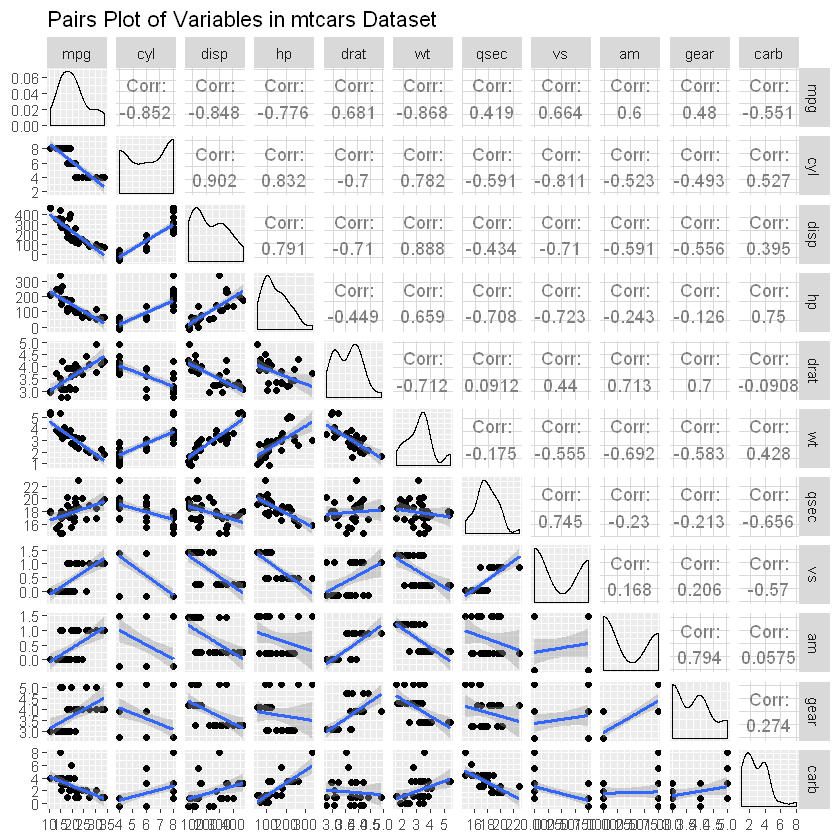

In [7]:
suppressMessages(suppressWarnings(library(dplyr)))
suppressMessages(suppressWarnings(library(bindrcpp)))
suppressMessages(suppressWarnings(library(ggplot2)))
library(dplyr)  # make sure you've done an install.packages so you have these
library(ggplot2)

suppressMessages(suppressWarnings(library(GGally)))
suppressMessages(suppressWarnings(library(ggplot2)))
library(GGally) #install.packages("GGally")

func <- function(dat=mtcars, mapping, method="loess", ...) {
    p <- ggplot(data = dat, mapping = mapping)
    p <- p + geom_point() + geom_smooth(method=method, ...)
    
    return(p)
}

g <- ggpairs(mtcars[, 2:ncol(mtcars)], lower = list(continuous = wrap(func, method="lm")),
             title = "Pairs Plot of Variables in mtcars Dataset")
print(g)

Let's take a look at the overall effect of transmission on MPG with this question in mind: *Is an automatic or manual transmission better for MPG?*  

Let's start by taking a look at a box plot comparing all the automatics against all the manual transmissions:

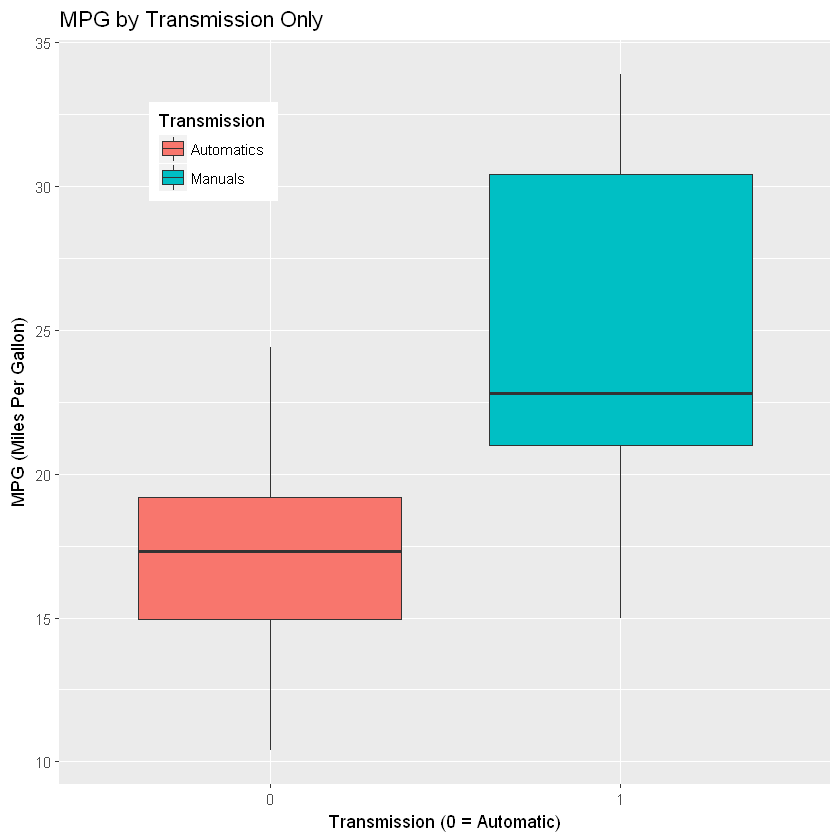

In [8]:
## PlotTools.R contains multiplot function
source('../../R/PlotTools.R')  # running notebook from docs/solutions/ dir under project

## boxplot to compare automatics vs manuals
p2 <- ggplot(mtcars, aes(factor(am), mpg))
p2 <- p2 + ggtitle("MPG by Transmission Only")
p2 <- p2 + geom_boxplot(aes(fill = factor(am)));
p2 <- p2 + scale_fill_discrete(name="Transmission", breaks=c(0,1),
                               labels=c("Automatics", "Manuals"))
p2 <- p2 + theme(legend.position=c(0.2,0.85))
p2 <- p2 + labs(x = "Transmission (0 = Automatic)", y = "MPG (Miles Per Gallon)")

print(p2)

The plot suggests that manuals get better mileage than automatics.  Let's see if a t-test confirms this:

In [9]:
t.test(mpg ~ factor(am), paired=FALSE, var.equal=FALSE, data=mtcars)


	Welch Two Sample t-test

data:  mpg by factor(am)
t = -3.7671, df = 18.332, p-value = 0.001374
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -11.280194  -3.209684
sample estimates:
mean in group 0 mean in group 1 
       17.14737        24.39231 


O.k., if we assume that other factors are **not** confounding our results, then the data suggests that manuals provide give better mileage.  So our next task is to check for factors that may be confounding the results.